In [1]:
import os
import requests
import numpy as np
import pandas as pd
import dateparser as dp

from universal import tools
from universal import algos

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16, 10) # increase the size of graphs
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
default_color_cycle = mpl.rcParams['axes.color_cycle'] # save this as we will want it back later
default_prop_cycle = mpl.rcParams['axes.prop_cycle']

import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.ERROR)

/Users/mark/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mark/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def get_ohlc(symbol,start_date='1 year ago',end_date='today',interval='daily'):
    assert('daily' in interval or 'weekly' in interval or 'monthly' in interval) 
    TOKEN = os.getenv('TIINGO_API_TOKEN')
    startDate = dp.parse(start_date).strftime('%Y-%m-%d')
    endDate = dp.parse(end_date).strftime('%Y-%m-%d')
    # https://api.tiingo.com/docs/tiingo/daily
    url = 'https://api.tiingo.com/tiingo/daily/{}/prices?startDate={}&endDate={}&resampleFreq={}&format=csv&token={}'.format(symbol,startDate,endDate,interval,TOKEN)
    data = requests.get(url).text
    if data:
        rows = data.split()
        d,o,h,l,c,v = [],[],[],[],[],[]
        for bar in rows[1:]:
            date,close_,high,low,open_,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor = bar.split(',')
            d.append(dp.parse(date))
            o.append(float(adjOpen))
            h.append(float(adjHigh))
            l.append(float(adjLow))
            c.append(float(adjClose))
            v.append(float(adjVolume))
            
        df = pd.DataFrame({'symbol':symbol, 'date': d, 'open':o, 'high':h, 'low':l, 'close':c, 'volume':v})
        return df
    return None

In [3]:
def get_funds(funds=None,start_date='1 year ago',end_date='today',interval='daily'):
    if funds is None:
        funds = ['VEXRX','VEXAX','VMFXX','VWEAX','VINIX','VWILX','VPMAX','VBTLX','VWIAX','VWENX','VWNEX','VEMAX','VINEX','VGSLX']
    data = []
    for fund in funds:
        df = get_ohlc(fund,start_date,end_date,interval)
        if df is not None:
            data.append(df)
    df = pd.concat(data,ignore_index=True)
    df['date'] = df.date.apply(lambda d: d.replace(tzinfo=None))
    return df

In [4]:
def get_closes(funds=None,start_date='1 year ago',end_date='today',interval='daily'):
    funds = get_funds(funds,start_date,end_date,interval)
    return pd.pivot_table(funds, values='close', index=['date'],columns=['symbol']).fillna(method='bfill')    

In [5]:
benchmark   = ['SPY']
funds       = ['VEXRX','VEXAX','VMFXX','VWEAX','VINIX','VWILX','VPMAX','VBTLX','VWIAX','VWENX','VWNEX','VEMAX','VINEX','VGSLX']
train_start = '2009-01-01'
train_end   = '2015-12-31'
test_start  = '2016-01-01' 
test_end    = 'today'
interval    = 'monthly'
train       = get_closes(funds=funds,start_date=train_start,end_date=train_end,interval=interval)
test        = get_closes(funds=funds,start_date=test_start,end_date=test_end,interval=interval)
train_b     = get_closes(funds=benchmark,start_date=train_start,end_date=train_end,interval=interval)
test_b      = get_closes(funds=benchmark,start_date=test_start,end_date=test_end,interval=interval)

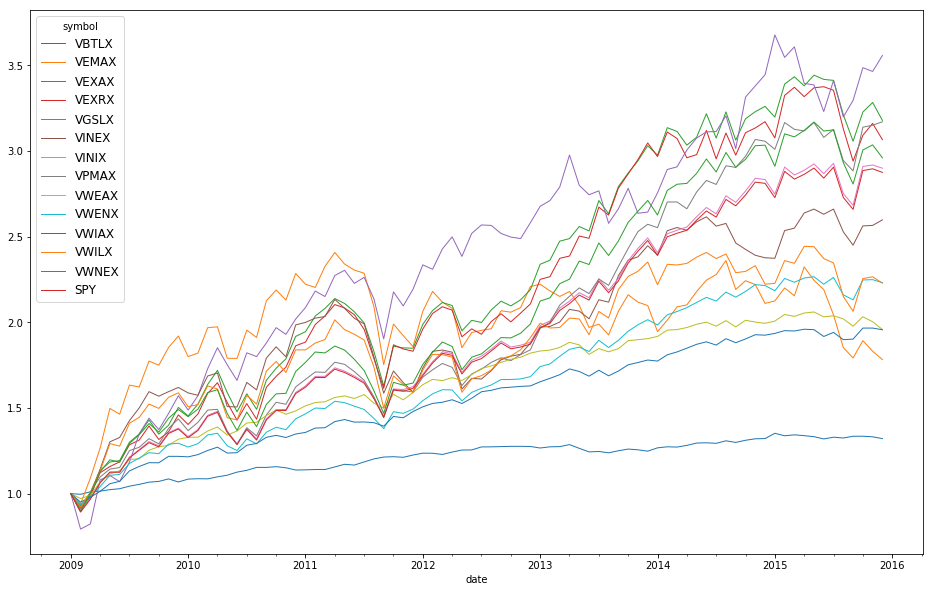

In [6]:
# plot normalized prices of the train set
ax1 = (train / train.iloc[0,:]).plot()
_ = (train_b / train_b.iloc[0,:]).plot(ax=ax1)

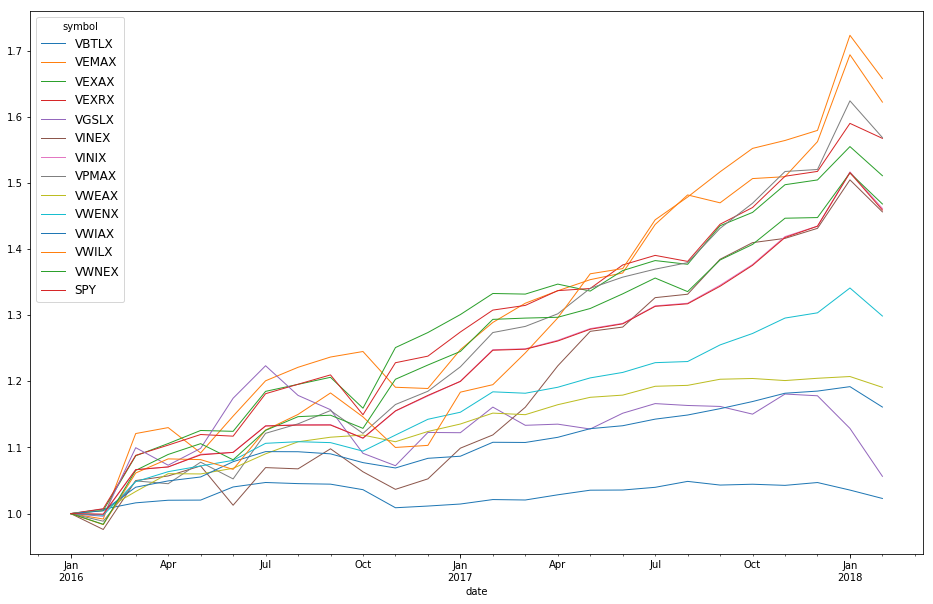

In [7]:
# plot normalized prices of the test set
ax2 = (test / test.iloc[0,:]).plot()
_ = (test_b / test_b.iloc[0,:]).plot(ax=ax2)

# Comparing the Algorithms

We want to train on market data from a number of years, and test out of sample for a duration smaller than the train set. To get started we accept the default parameters for the respective algorithms and we essentially are just looking at two independent time periods.  In the future we will want to optimize the paramaters on the train set.

In [8]:
#list all the algos
olps_algos = [
algos.Anticor(),
algos.BAH(),
algos.BCRP(),
algos.CWMR(),
algos.EG(),
algos.OLMAR(),
algos.ONS(),
algos.PAMR(),
algos.RMR(),
]
#algos.Kelly(),
#algos.UP()
#algos.CORN(),
#algos.BNN(),

In [9]:
# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

At this point we could train all the algos to find the best parameters for each.

In [18]:
# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    print("running: {}".format(name))
    olps_train.loc[name,'results'] = alg.run(train)

running: Anticor
running: BAH
running: BCRP
running: CWMR
running: EG
running: OLMAR
running: ONS
running: PAMR
running: RMR


In [11]:
# Let's make sure the fees are set to 0
for k, r in olps_train.results.iteritems():
    r.fee = 0.0

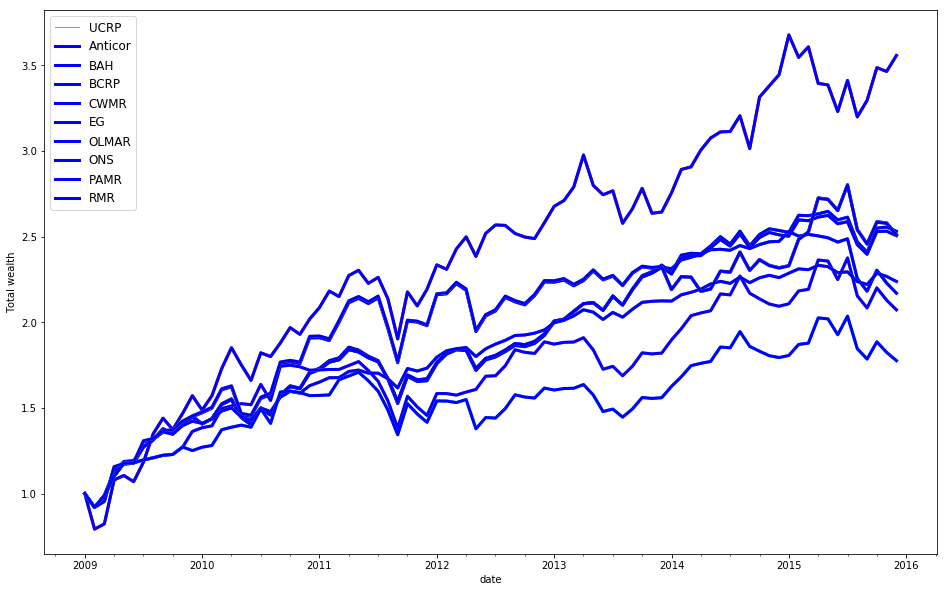

In [12]:
# get the first result so we can grab the figure axes from the plot
ax = olps_train.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_train.index[0])
for k, r in olps_train.results.iteritems():
    if k == olps_train.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [13]:
def olps_stats(df):
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    return df

In [15]:
olps_stats(olps_train)
olps_train[metrics].sort_values('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,2.94333,1.23841,-0.308817,12.3432,166.093,67.4699
EG,2.21471,1.04429,0.233124,14.1896,207.616,66.2651
BAH,2.16415,1.01908,0.229352,14.3573,332.186,65.0602
Anticor,1.96098,0.857327,-0.572391,11.841,228.378,65.0602
BCRP,1.94525,0.844615,0.358267,20.1199,228.378,63.8554
CWMR,1.91462,0.770893,0.0049499,14.2318,186.855,61.4458
PAMR,1.91206,0.7689,0.00311407,14.2128,186.855,61.4458
OLMAR,1.74937,0.686782,-0.274927,11.1024,311.425,62.6506
RMR,1.51963,0.520421,-0.502123,8.65088,685.134,59.0361


Summary:
    Profit factor: 2.94
    Sharpe ratio: 1.24
    Information ratio (wrt UCRP): -0.31
    Annualized return: 12.34%
    Annualized volatility: 9.62%
    Longest drawdown: 166 days
    Max drawdown: 8.03%
    Winning days: 67.5%
        


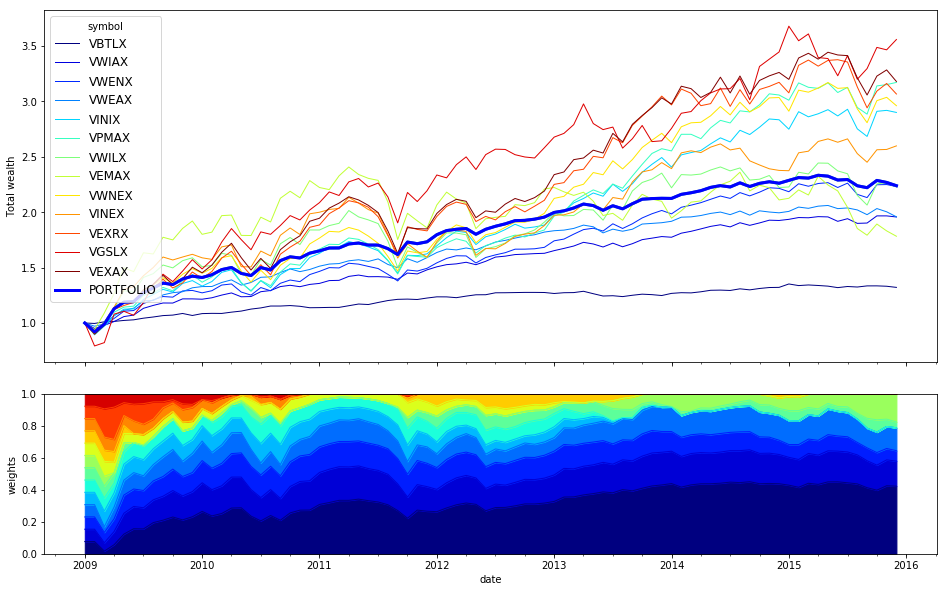

In [16]:
#algo = algos.Anticor()
#algo = algos.BAH()
#algo = algos.BCRP()
#algo = algos.BNN()
#algo = algos.CORN()
#algo = algos.CRP()
#algo = algos.CWMR()
#algo = algos.EG()
#algo = algos.Kelly()
#algo = algos.OLMAR()
algo = algos.ONS()
#algo = algos.PAMR()
#algo = algos.RMR()
#algo = algos.UP()
#algo = algos.DynamicCRP(n=52, min_history=8)

result = algo.run(train)
result.fee = 0.0
print(result.summary())
_=result.plot()

Summary:
    Profit factor: 5.47
    Sharpe ratio: 1.91
    Information ratio (wrt UCRP): -1.40
    Annualized return: 12.44%
    Annualized volatility: 6.24%
    Longest drawdown: 40 days
    Max drawdown: 2.94%
    Winning days: 84.0%
        


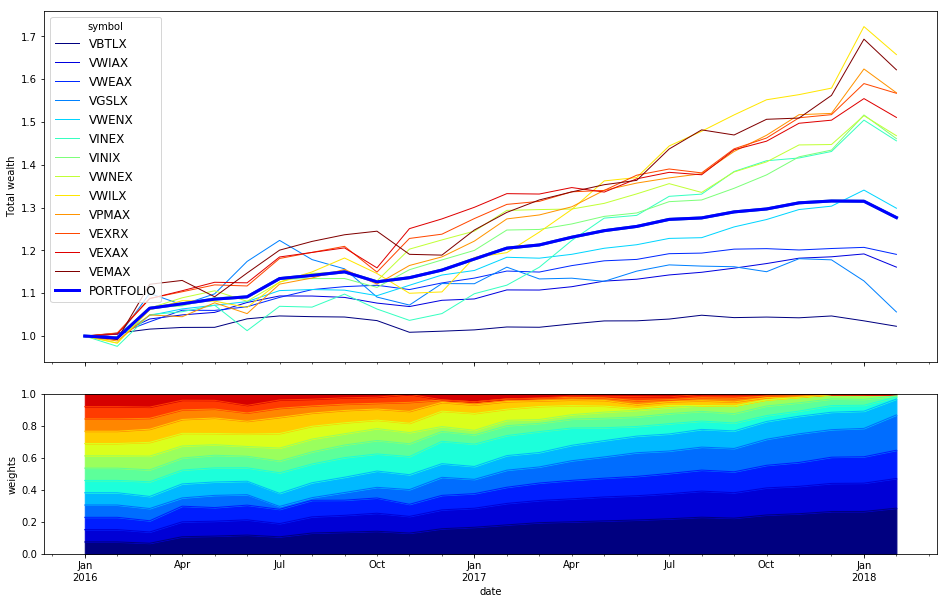

In [17]:
result = algo.run(test)
result.fee = 0.0
print(result.summary())
_=result.plot()